<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import shutil
import unittest
from catvae.trainer import MultBatchVAE, BiomDataModule
from catvae.sim import multinomial_batch_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import torch
import argparse
import seaborn as sns
import pandas as pd

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

from pytorch_lightning.profiler import AdvancedProfiler
%matplotlib inline

In [2]:
np.random.seed(0)
k = 10
C = 3
D = 40
sims = multinomial_batch_bioms(k=k, D=D, N=500, M=1e6, C=C)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

md = pd.DataFrame({'batch_category': sims['batch_idx']}, index=samp_ids)
md.index.name = 'sampleid'
md.to_csv('metadata.txt', sep='\t')
batch_priors = pd.Series(sims['alphaILR'])
batch_priors.to_csv('batch_priors.txt', sep='\t')

beta_prior = torch.Tensor(batch_priors.values).float()
sims['tree'].write('basis.nwk')

'basis.nwk'

Run batch effects removal VAE

In [3]:
output_dir = 'output'

dm = BiomDataModule('train.biom', 'test.biom', 'valid.biom',
                    metadata='metadata.txt',
                    batch_category='batch_category',
                    batch_size=50)
model = MultBatchVAE(n_input=D, n_latent=k,
                     n_hidden=16, n_batches=C,
                     basis='basis.nwk', 
                     beta_prior=1,
                     gam_prior=1, phi_prior=1,
                     dropout=0, bias=True, batch_norm=False,
                     encoder_depth=1, learning_rate=0.1, vae_lr=0.1,
                     scheduler='cosine', transform='pseudocount')
print(model)

MultBatchVAE(
  (vae): LinearBatchVAE(
    (encoder): Encoder(
      (encoder): Linear(in_features=39, out_features=10, bias=True)
    )
    (decoder): ParametrizedLinear(
      in_features=10, out_features=39, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizedGrassmannian(
          n=39, k=10, triv=expm
          (parametrizations): ModuleDict(
            (original): ParametrizedStiefel(
              n=39, k=10, triv=expm
              (parametrizations): ModuleDict(
                (original): ParametrizedSO(
                  n=39, triv=expm
                  (parametrizations): ModuleDict(
                    (original): ParametrizedSkew(
                      n=39
                      (parametrizations): ModuleDict(
                        (original): ParametrizedEmbeddingStiefel(
                          (parametrizations): ModuleDict(
                            (original): EmbeddingGrassmannian()
                          )
                     

In [4]:
trainer = Trainer(
    max_epochs=100,
    gpus=1,
    check_val_every_n_epoch=1,
    fast_dev_run=False,
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name | Type           | Params
----------------------------------------
0 | vae  | LinearBatchVAE | 1.5 K 
----------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/mnt/home/jmorton/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/mnt/home/jmorton/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(0.8402331127474414, 1.2638778703646628e-198)


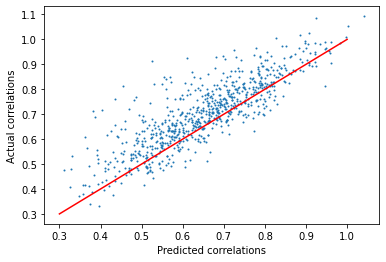

In [5]:
W = model.vae.decoder.weight.detach().cpu().numpy()
d_estW = pdist(W)
simW = sims['W'] / np.sqrt(sims['eigs'])
dW = pdist(simW)

plt.scatter(dW, d_estW, s=1)
plt.plot(np.linspace(0.3, 1), np.linspace(0.3, 1), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

(0.5590332629411481, 0.0)


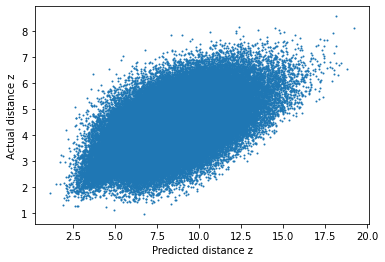

In [6]:
x = torch.Tensor(sims['Y']).float()
b = torch.Tensor(sims['batch_idx']).long()
z = model.vae.encode(x, b)

dsimz = pdist(sims['z'])
dz = pdist(z.detach().cpu().numpy())
plt.scatter(dz, dsimz, s=1)
plt.xlabel('Predicted distance z')
plt.ylabel('Actual distance z')
print(pearsonr(dz, dsimz))

(0.46796051168741315, 1.356487220218993e-41)


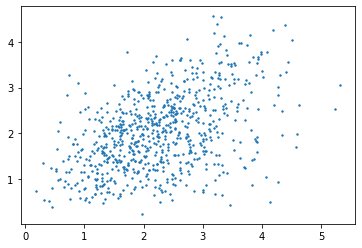

In [10]:
simB = sims['B'].T
B = model.vae.beta.weight.detach().cpu().numpy().T

plt.scatter(np.ravel(pdist(B)), np.ravel(pdist(simB)), s=2)
print(pearsonr(pdist(B).ravel(), pdist(simB).ravel()))